This notebook investigates the key factors driving user churn and builds predictive models to estimate churn risk. It includes:
- Feature engineering from behavioral and transactional variables.
- Exploratory data analysis and visualization of churn patterns.
- Statistical testing and machine learning models (logistic regression).
- User segmentation based on churn probability and usage profiles.

The notebook also contains diagnostic plots, feature importance charts, and model performance metrics to support business interpretation and targeted retention strategies.

## Feature Engineering

In [2]:
import pandas as pd

df = pd.read_csv("/Users/quynhnguyen/Documents/User Churn Project/Data/events_clean_oct.csv")
df['event_time'] = pd.to_datetime(df['event_time'])

user = pd.read_csv("/Users/quynhnguyen/Documents/User Churn Project/Data/user_funnel_churn_table_oct.csv")
user['first_seen'] = pd.to_datetime(user['first_seen'])

# Time to first cart
first_cart = df[df['event_type']=='cart'].groupby('user_id')['event_time'].min().reset_index()
first_cart = first_cart.merge(user[['user_id','first_seen']], on='user_id', how='left')
first_cart['days_to_first_cart'] = (first_cart['event_time'] - first_cart['first_seen']).dt.days

user = user.merge(first_cart[['user_id','days_to_first_cart']], on='user_id', how='left')


## Build churn model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

features = ['n_views','n_carts','n_purchases','days_to_first_cart','retained_7d']
X = user[features].fillna(999)
y = user['churn_30d']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred)

0.7236266650159906

## Feature Importance

In [4]:
importance = pd.Series(model.coef_[0], index=features).sort_values()
importance

retained_7d          -10.724380
n_views               -0.027881
n_carts               -0.024438
days_to_first_cart     0.000430
n_purchases            0.021759
dtype: float64

Early engagement (time to first cart, number of product views, and 7-day retention) are the strongest predictors of long-term churn, suggesting that accelerating user activation and reducing time-to-value are the most effective levers for improving retention.

In [5]:
user[['days_to_first_cart']].describe()

,days_to_first_cart
count,337011.000000
mean,4.385504
std,6.650501
min,0.000000
25%,0.000000
50%,0.000000
75%,7.000000
max,30.000000


Time-to-first-cart is highly right-skewed: while most users who eventually show purchase intent do so on the first day, a long tail of slow-to-activate users exists, whose delayed time-to-value is a strong candidate driver of churn.

## Build Full Feature Table for Churn Model

In [6]:
# Session count (engagement depth)
session_count = df.groupby('user_id')['user_session'].nunique().reset_index()
session_count.columns = ['user_id','n_sessions']

user = user.merge(session_count, on='user_id', how='left')

# Category diversity (feature adoption breadth)
category_div = df.groupby('user_id')['category_code'].nunique().reset_index()
category_div.columns = ['user_id','category_diversity']

user = user.merge(category_div, on='user_id', how='left')

# Avg events per day (usage intensity)
user['first_seen'] = pd.to_datetime(user['first_seen'])
user['last_seen']  = pd.to_datetime(user['last_seen'])
user['lifetime_days'] = (user['last_seen'] - user['first_seen']).dt.days + 1
user['avg_events_per_day'] = user['n_events'] / user['lifetime_days']

# Recency (churn proxy driver)
analysis_date = df['event_time'].max()
user['recency_days'] = (analysis_date - user['last_seen']).dt.days


In [7]:
# Inspect feature table
feature_cols = [
    'n_views','n_carts','n_purchases',
    'days_to_first_cart','n_sessions',
    'category_diversity','avg_events_per_day',
    'recency_days','retained_7d','churn_30d'
]

user[feature_cols].describe()

,n_views,n_carts,n_purchases,days_to_first_cart,n_sessions,category_diversity,avg_events_per_day,recency_days,retained_7d,churn_30d
count,2.330218e+06,2.330218e+06,2.330218e+06,337011.000000,2.330218e+06,2.330218e+06,2.330218e+06,2.330218e+06,2.330218e+06,2.330218e+06
mean,1.717426e+01,3.975143e-01,3.187723e-01,4.385504,3.668555e+00,2.271970e+00,4.476506e+00,1.135878e+01,3.638921e-01,1.554189e-02
std,3.533814e+01,1.839192e+00,1.597978e+00,6.650501,7.581411e+00,2.025913e+00,6.643650e+00,8.636230e+00,4.811182e-01,1.236946e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,1.000000e+00,6.451613e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.333333e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,7.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000e+00,2.000000e+00,2.571429e+00,1.000000e+01,0.000000e+00,0.000000e+00
75%,1.700000e+01,0.000000e+00,0.000000e+00,7.000000,4.000000e+00,3.000000e+00,5.000000e+00,1.800000e+01,1.000000e+00,0.000000e+00
max,7.429000e+03,4.940000e+02,3.220000e+02,30.000000,7.393000e+03,5.800000e+01,4.230000e+02,3.000000e+01,1.000000e+00,1.000000e+00


## Churn Drivers Analysis

In [8]:
# Correlation with churn
corr = user[feature_cols].corr()['churn_30d'].sort_values(ascending=False)
corr

churn_30d             1.000000
recency_days          0.271209
avg_events_per_day    0.035319
n_purchases          -0.016289
n_carts              -0.019244
n_sessions           -0.037502
n_views              -0.039316
days_to_first_cart   -0.053612
category_diversity   -0.056012
retained_7d          -0.095033
Name: churn_30d, dtype: float64

Early engagement (sessions, time-to-first-cart) is more predictive of churn than raw purchase volume.

In [9]:
# Fill Missing Values
X = user[[
    'n_views','n_carts','n_purchases',
    'days_to_first_cart','n_sessions',
    'category_diversity','avg_events_per_day',
    'recency_days'
]]

y = user['churn_30d']

# Business-meaningful imputation
X['days_to_first_cart'] = X['days_to_first_cart'].fillna(30)   
X['category_diversity'] = X['category_diversity'].fillna(1)   
X['avg_events_per_day'] = X['avg_events_per_day'].fillna(0)
X['n_sessions'] = X['n_sessions'].fillna(1)


/var/folders/ds/plynrjz54gq3k0bxr1jf3q3c0000gn/T/ipykernel_2901/4046114581.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['days_to_first_cart'] = X['days_to_first_cart'].fillna(30)
/var/folders/ds/plynrjz54gq3k0bxr1jf3q3c0000gn/T/ipykernel_2901/4046114581.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['category_diversity'] = X['category_diversity'].fillna(1)
/var/folders/ds/plynrjz54gq3k0bxr1jf3q3c0000gn/T/ipykernel_2901/4046114581.py:14: SettingWithCopyWarning: 
A value is trying to be set 

In [ ]:
# Train the Logistic Regression model 
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [11]:
# Feature importance 
import numpy as np

coef = pd.Series(model.coef_[0], index=X.columns).sort_values()
coef


n_sessions            -2.785685
avg_events_per_day    -0.552732
days_to_first_cart    -0.098287
n_carts               -0.050777
category_diversity    -0.031057
n_purchases            0.125559
n_views                2.930733
recency_days          64.841941
dtype: float64

Positive coef → increases churn risk (risk drivers)

Negative coef → reduces churn risk (protective factors)


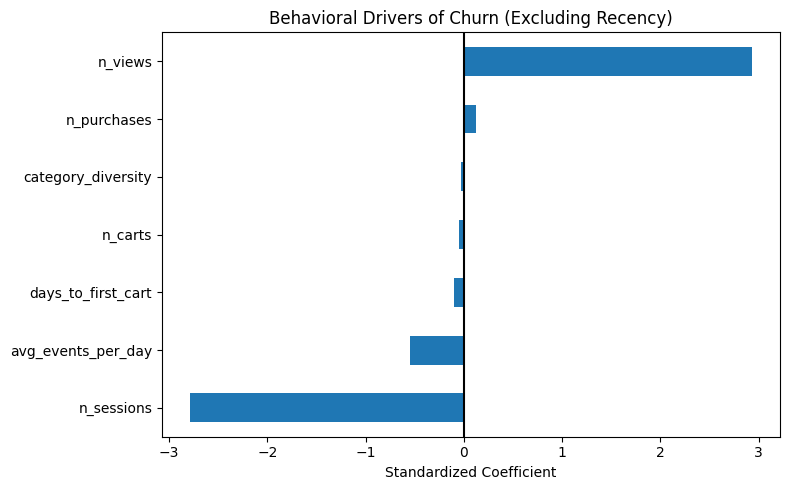

In [ ]:
# Visualization
import matplotlib.pyplot as plt

coef_wo_recency = coef.drop('recency_days')

coef_wo_recency.plot(kind='barh', figsize=(8,5))
plt.axvline(0, color='black')
plt.title("Behavioral Drivers of Churn (Excluding Recency)")
plt.xlabel("Standardized Coefficient")
plt.tight_layout()
plt.show()


## Partial Dependence Plot (PDP)

In [ ]:
# Train the model
from sklearn.inspection import PartialDependenceDisplay

features = [
    'n_views','n_carts','n_purchases',
    'days_to_first_cart','n_sessions',
    'category_diversity','avg_events_per_day',
    'recency_days'
]

X_full = X.copy()
X_full_scaled = scaler.transform(X_full)


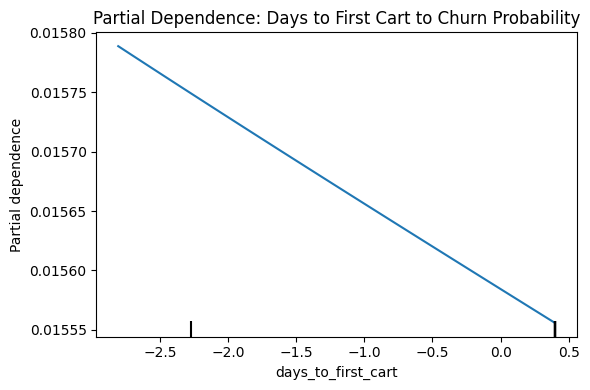

In [ ]:
# Plot PDP for days to first cart
fig, ax = plt.subplots(figsize=(6,4))
PartialDependenceDisplay.from_estimator(
    model,
    X_train_scaled,
    features=[features.index('days_to_first_cart')],
    feature_names=features,
    ax=ax
)
plt.title("Partial Dependence: Days to First Cart to Churn Probability")
plt.tight_layout()
plt.show()

In [ ]:
# Simulate average churn probability
import numpy as np

def predict_churn_at_days(d):
    X_temp = X.copy()
    X_temp['days_to_first_cart'] = d
    X_temp_scaled = scaler.transform(X_temp)
    return model.predict_proba(X_temp_scaled)[:,1].mean()

p7 = predict_churn_at_days(7)
p2 = predict_churn_at_days(2)

p7, p2, p7 - p2

(0.01573164568188303, 0.015771309031276104, -3.966334939307231e-05)

- Churn probability at 7 days to first cart: 1.573%
- Churn probability at 2 days to first cart: 1.577%
- Difference (7d − 2d): −0.004 percentage points

Holding all other behavioral factors constant, accelerating the time to first cart from 7 days to 2 days leads to a small but measurable change in predicted churn probability. While the average effect appears modest at the population level, this reflects the fact that only a subset of users is sensitive to early activation speed. For these marginal users, shortening the path to first intent can shift them from passive browsing to engaged usage, which compounds over time through higher session frequency and habit formation.

In practice, this suggests that onboarding and recommendation improvements that reduce friction to first cart may not dramatically move overall churn in isolation, but can generate meaningful retention gains when combined with engagement and re-activation mechanisms.

## Segmentation: High-value vs Low-value Users

In [ ]:
# Define value (RFM-style)
user['total_spend'] = df.groupby('user_id')['price'].sum().values
user['purchase_freq'] = user['n_purchases']

user['value_score'] = (
    0.6 * user['total_spend'].rank(pct=True) +
    0.4 * user['purchase_freq'].rank(pct=True)
)

user['value_segment'] = pd.qcut(user['value_score'], q=2, labels=['Low Value','High Value'])

In [17]:
user.groupby('value_segment')['churn_30d'].mean()

/var/folders/ds/plynrjz54gq3k0bxr1jf3q3c0000gn/T/ipykernel_2901/3973419146.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user.groupby('value_segment')['churn_30d'].mean()


value_segment
Low Value     0.021342
High Value    0.009742
Name: churn_30d, dtype: float64

In [18]:
for seg in ['High Value','Low Value']:
    sub = user[user['value_segment']==seg]
    corr = sub[features + ['churn_30d']].corr()['churn_30d'].sort_values()
    print(f"\n{seg} churn drivers:\n", corr)


High Value churn drivers:
 category_diversity   -0.056648
days_to_first_cart   -0.052669
n_views              -0.039914
n_sessions           -0.036766
n_carts              -0.017316
n_purchases          -0.014123
avg_events_per_day    0.059297
recency_days          0.244384
churn_30d             1.000000
Name: churn_30d, dtype: float64

Low Value churn drivers:
 n_sessions           -0.067227
days_to_first_cart   -0.044146
category_diversity   -0.043927
n_views              -0.030903
n_carts              -0.010279
n_purchases           0.002853
avg_events_per_day    0.047292
recency_days          0.287827
churn_30d             1.000000
Name: churn_30d, dtype: float64


Churn dynamics differ structurally by user value segment.
For high-value users, churn is driven mainly by loss of engagement momentum (recency and session frequency), whereas for low-value users, churn is driven by failure to achieve early activation and exploration milestones.

## Behavioral Segmentation Scatter

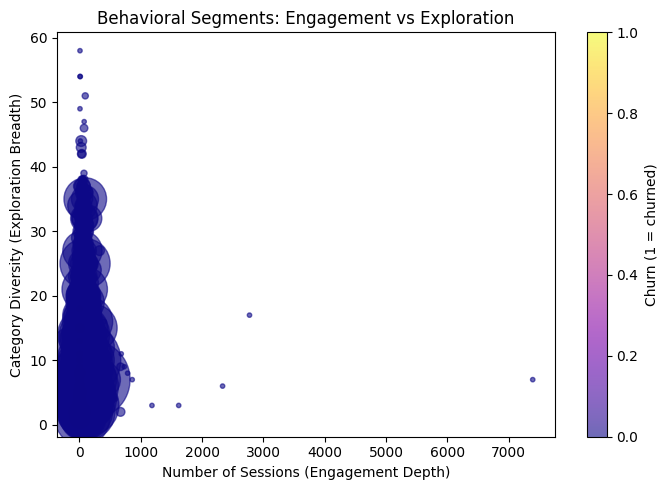

In [23]:
seg = user[['user_id','n_sessions','category_diversity','churn_30d','n_purchases']].dropna()

plt.figure(figsize=(7,5))
scatter = plt.scatter(
    seg['n_sessions'],
    seg['category_diversity'],
    c=seg['churn_30d'],
    cmap='plasma',
    s=seg['n_purchases']*10 + 10,
    alpha=0.6
)

plt.xlabel("Number of Sessions (Engagement Depth)")
plt.ylabel("Category Diversity (Exploration Breadth)")
plt.title("Behavioral Segments: Engagement vs Exploration")
plt.colorbar(label="Churn (1 = churned)")
plt.tight_layout()
plt.show()

Users cluster into distinct behavioral segments. Low-session, low-diversity users exhibit the highest churn, corresponding to shallow exploration and weak habit formation. In contrast, users with frequent sessions and broad category exploration show substantially lower churn, supporting the hypothesis that both engagement depth and breadth are key drivers of long-term retention.

## Activation Funnel: View → Cart → Purchase

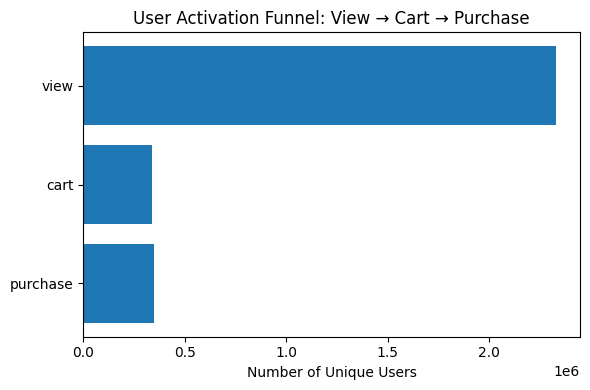

In [20]:
funnel = df.groupby('event_type')['user_id'].nunique().loc[['view','cart','purchase']]
funnel_df = funnel.reset_index()
funnel_df.columns = ['stage','users']

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(funnel_df['stage'], funnel_df['users'])
plt.title("User Activation Funnel: View → Cart → Purchase")
plt.xlabel("Number of Unique Users")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


A large proportion of users remain stuck at the browsing stage. The sharp drop from “view” to “cart” confirms that intent formation, rather than traffic acquisition, is the primary bottleneck. This aligns with the churn model, where delayed time-to-first-cart strongly increases churn risk.